### Подключаем основные модули

In [1]:
import os
import pandas as pd

pd.options.display.max_columns = 100

from dotenv import load_dotenv, find_dotenv
import seaborn as sns


### Подключаемся к базе и загружаем основные таблицы

In [2]:
load_dotenv(find_dotenv())
DB_CONNECTION = os.getenv('DB_CONNECTION')

In [3]:
users = pd.read_sql(
    """
    SELECT *
    FROM public.user_data
    """,
    con=DB_CONNECTION
)
posts = pd.read_sql(
    """
    SELECT *
    FROM public.post_text_df
    """,
    con=DB_CONNECTION
)


<div class="alert alert-block">
<h2> Таблица user_data </h2>
<b><i> Cодержит информацию о всех пользователях соц.сети </i> </b>
</div>

| Field name |	Overview|
|------------|----------|
| age	| Возраст пользователя (в профиле)|
| city	| Город пользователя (в профиле)|
| country	| Страна пользователя (в профиле)|
| exp_group	| Экспериментальная группа: некоторая зашифрованная категория|
| gender	| Пол пользователя|
| id	| Уникальный идентификатор пользователя|
| os	| Операционная система устройства, с которого происходит пользование соц.сетью|
| source	|Пришел ли пользователь в приложение с органического трафика или с рекламы|

In [4]:
users.head(5)

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


<b> Посмотрим, какие пользователи есть в нашей соц. сети</b>

In [5]:
users.describe(include="object")

,country,city,os,source
count,163205,163205,163205,163205
unique,11,3915,2,2
top,Russia,Moscow,Android,ads
freq,143035,21874,105972,101685


In [6]:
users.age.describe()

count    163205.000000
mean         27.195405
std          10.239158
min          14.000000
25%          19.000000
50%          24.000000
75%          33.000000
max          95.000000
Name: age, dtype: float64

<b> Средний возраст пользователей - 27 лет, наименьший - 14 лет, наибольший - 95 лет. </b>

In [7]:
users.country.value_counts()

country
Russia         143035
Ukraine          8273
Belarus          3293
Kazakhstan       3172
Turkey           1606
Finland          1599
Azerbaijan       1542
Estonia           178
Latvia            175
Cyprus            170
Switzerland       162
Name: count, dtype: int64

<b> Большая часть пользователей из России </b>

In [8]:
users.gender.value_counts()

gender
1    89980
0    73225
Name: count, dtype: int64

<div class="alert alert-block">
<h2> Таблица post_text_df </h2>
<b><i> Содержит информацию о постах: уникальный ID каждого поста с соответствующим ей текстом и топиком</i></b>
</div>

| Field name |	Overview|
|------------|----------|
| id	| Уникальный идентификатор поста |
| text	| Текстовое содержание поста |
| topic	| Основная тематика |

In [9]:
posts.head(5)

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [10]:
posts["topic"].value_counts()

topic
movie            3000
covid            1799
business          510
sport             510
politics          417
tech              401
entertainment     386
Name: count, dtype: int64

### Подгружаем таблицу с информацией о просмотренных постах и лайках.
<div class="alert alert-block">
<h2>Таблица feed_data </h2>
<b> <i>Содержит информацию о действиях пользователей с указанием времени действия. </i></b>
</div>

| Field name |	Overview|
|------------|----------|
| timestamp	| Время, когда был произведен просмотр|
|user_id	| id пользователя, который совершил просмотр|
|post_id	| id просмотренного поста|
|action	|Тип действия: просмотр или лайк|
|target	|1 у просмотров, если почти сразу после просмотра был совершен лайк, иначе 0. У действий like пропущенное значение. |

In [11]:
counts  = pd.read_sql(
    """
    SELECT count(*)
    FROM public.feed_data
    """,
    con=DB_CONNECTION
)
counts

,count
0,76892800


<b> Размер этой таблицы слишком большой, возьмем кусочек в 1 млн. строк </b> 

In [12]:
feed_data = pd.read_sql(
    """
    SELECT timestamp, user_id, post_id, target
    FROM public.feed_data
    WHERE action != 'like'
    LIMIT 1000000
    """,
    con=DB_CONNECTION
)

In [13]:
feed_data.head(5)

,timestamp,user_id,post_id,target
0,2021-11-17 10:53:29,91344,415,0
1,2021-11-17 10:55:35,91344,1533,0
2,2021-11-17 10:58:33,91344,717,0
3,2021-11-17 11:00:06,91344,1983,1
4,2021-11-17 11:01:46,91344,149,0


### Смержим таблицы для извлечения информации.

In [14]:
feed_features_default = pd.merge(feed_data, users, on="user_id")
feed_features_default = pd.merge(feed_features_default, posts, on="post_id")
feed_features_default.head(5)

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-11-17 10:53:29,91344,415,0,1,33,Russia,Domodedovo,1,iOS,ads,India seeks to boost construction\n\nIndia has...,business
1,2021-11-17 10:55:35,91344,1533,0,1,33,Russia,Domodedovo,1,iOS,ads,Verdict delay for Greek sprinters\n\nGreek ath...,sport
2,2021-11-17 10:58:33,91344,717,0,1,33,Russia,Domodedovo,1,iOS,ads,Wife Swap makers sue US copycat\n\nThe British...,entertainment
3,2021-11-17 11:00:06,91344,1983,1,1,33,Russia,Domodedovo,1,iOS,ads,US hacker breaks into T-Mobile\n\nA man is fac...,tech
4,2021-11-17 11:01:46,91344,149,0,1,33,Russia,Domodedovo,1,iOS,ads,GSK aims to stop Aids profiteers\n\nOne of the...,business


### Выведем основную информацию о датасете

In [15]:
feed_features_default.drop(["user_id", "post_id", "text"], axis=1).describe()

,timestamp,target,gender,age,exp_group
count,1000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,2021-11-14 23:30:35.501783040,0.121507,0.543194,27.259013,1.950854
min,2021-10-01 06:06:45,0.000000,0.000000,14.000000,0.000000
25%,2021-10-23 12:38:49.750000128,0.000000,0.000000,19.000000,1.000000
50%,2021-11-14 15:29:24,0.000000,1.000000,24.000000,2.000000
75%,2021-12-07 15:42:13,0.000000,1.000000,34.000000,3.000000
max,2021-12-29 23:43:27,1.000000,1.000000,75.000000,4.000000
std,NaN,0.326716,0.498131,10.355178,1.387998


<b> По времени данные распределены с октября до декабрь 2021 года.</b>

In [16]:
feed_features_default.drop("text", axis=1).describe(include="object")

,country,city,os,source,topic
count,1000000,1000000,1000000,1000000,1000000
unique,11,724,2,2,7
top,Russia,Moscow,Android,organic,movie
freq,871345,133572,643391,704919,369361


In [17]:
print(feed_data["target"].value_counts())

target
0    878493
1    121507
Name: count, dtype: int64


<b> В датасете серьезный дисбаланс классов - отрицательных классов в ~ 7.5 раз больше, чем положительных. </b>





### Посмотрим на распределения дефолтных фичей

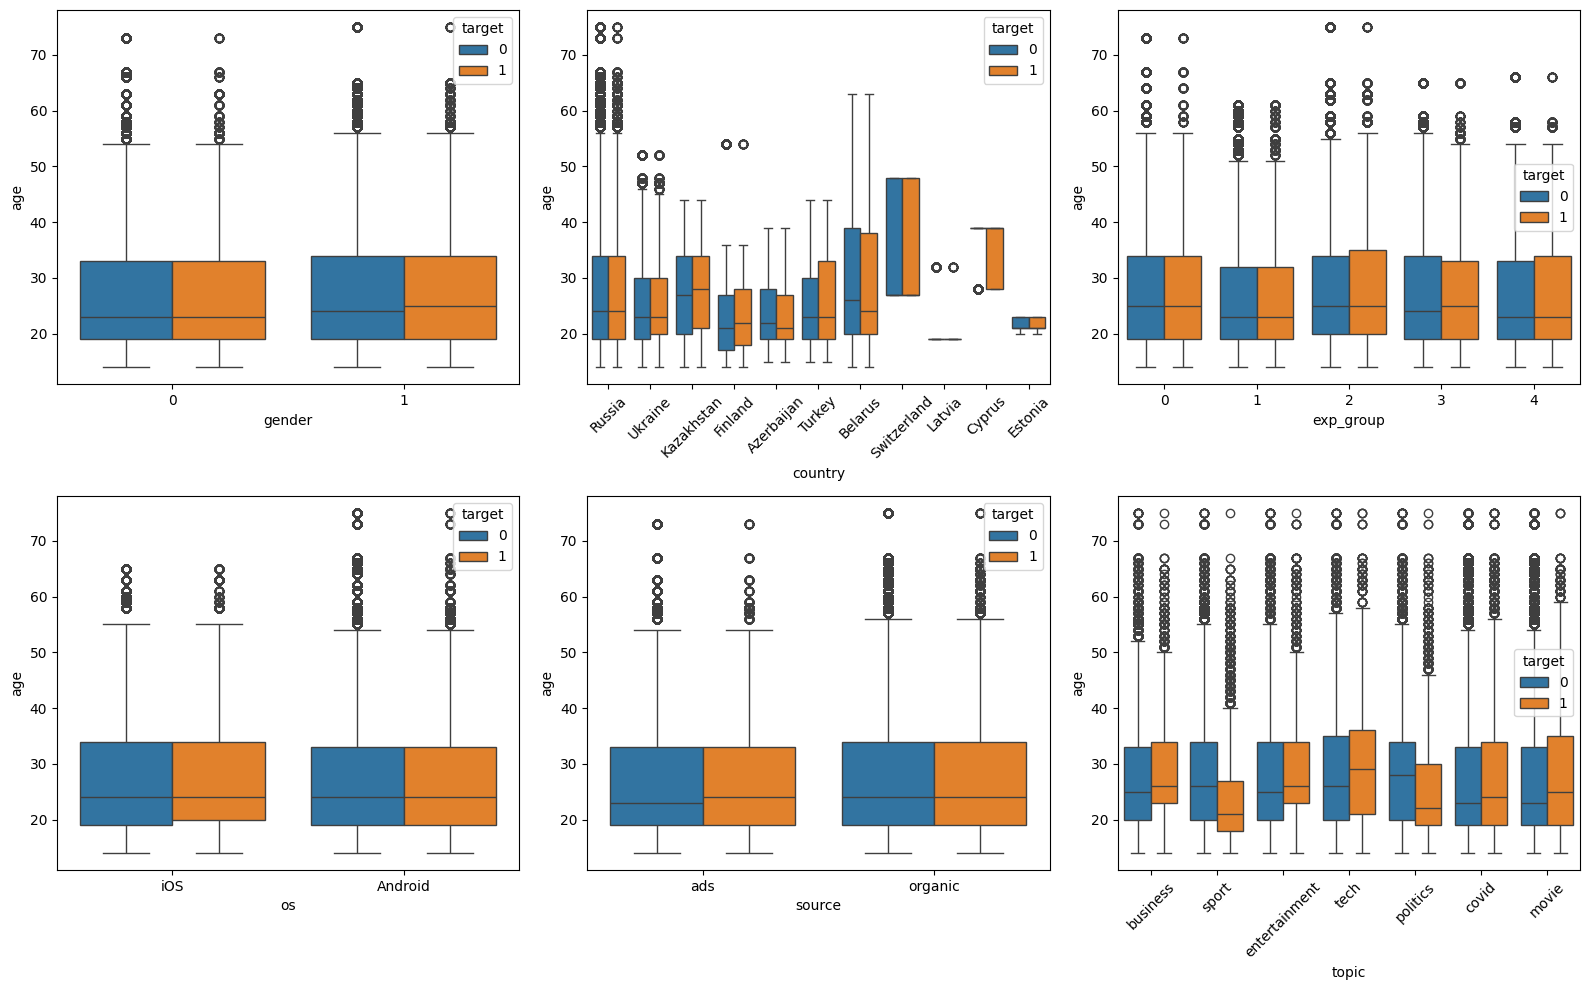

In [18]:
from matplotlib import pyplot as plt


cat_cols_for_boxplot = feed_features_default.drop(
    ['timestamp', 'user_id', 'post_id', 'target', 'age', 'city', 'text'],
    axis=1
).columns.to_list()


fig,ax=plt.subplots(2,3,figsize=(16,10))
for id, col_name in enumerate(cat_cols_for_boxplot):
    row, col = id//3, id%3
    if id in [1,5]:
        ax[row, col].tick_params(axis='x', labelrotation=45)
    sns.boxplot(data=feed_features_default, x=col_name, y="age", hue="target", ax=ax[row, col])

plt.tight_layout()


<b> Отсюда можно заметить, что интересующие пользователей темы напрямую зависят от их возраста. Так, например спортивные посты лайкают преимущественно молодые ребята до ~26 лет. С другой стороны посты про технологии уже нравятся людям постарше. </b>

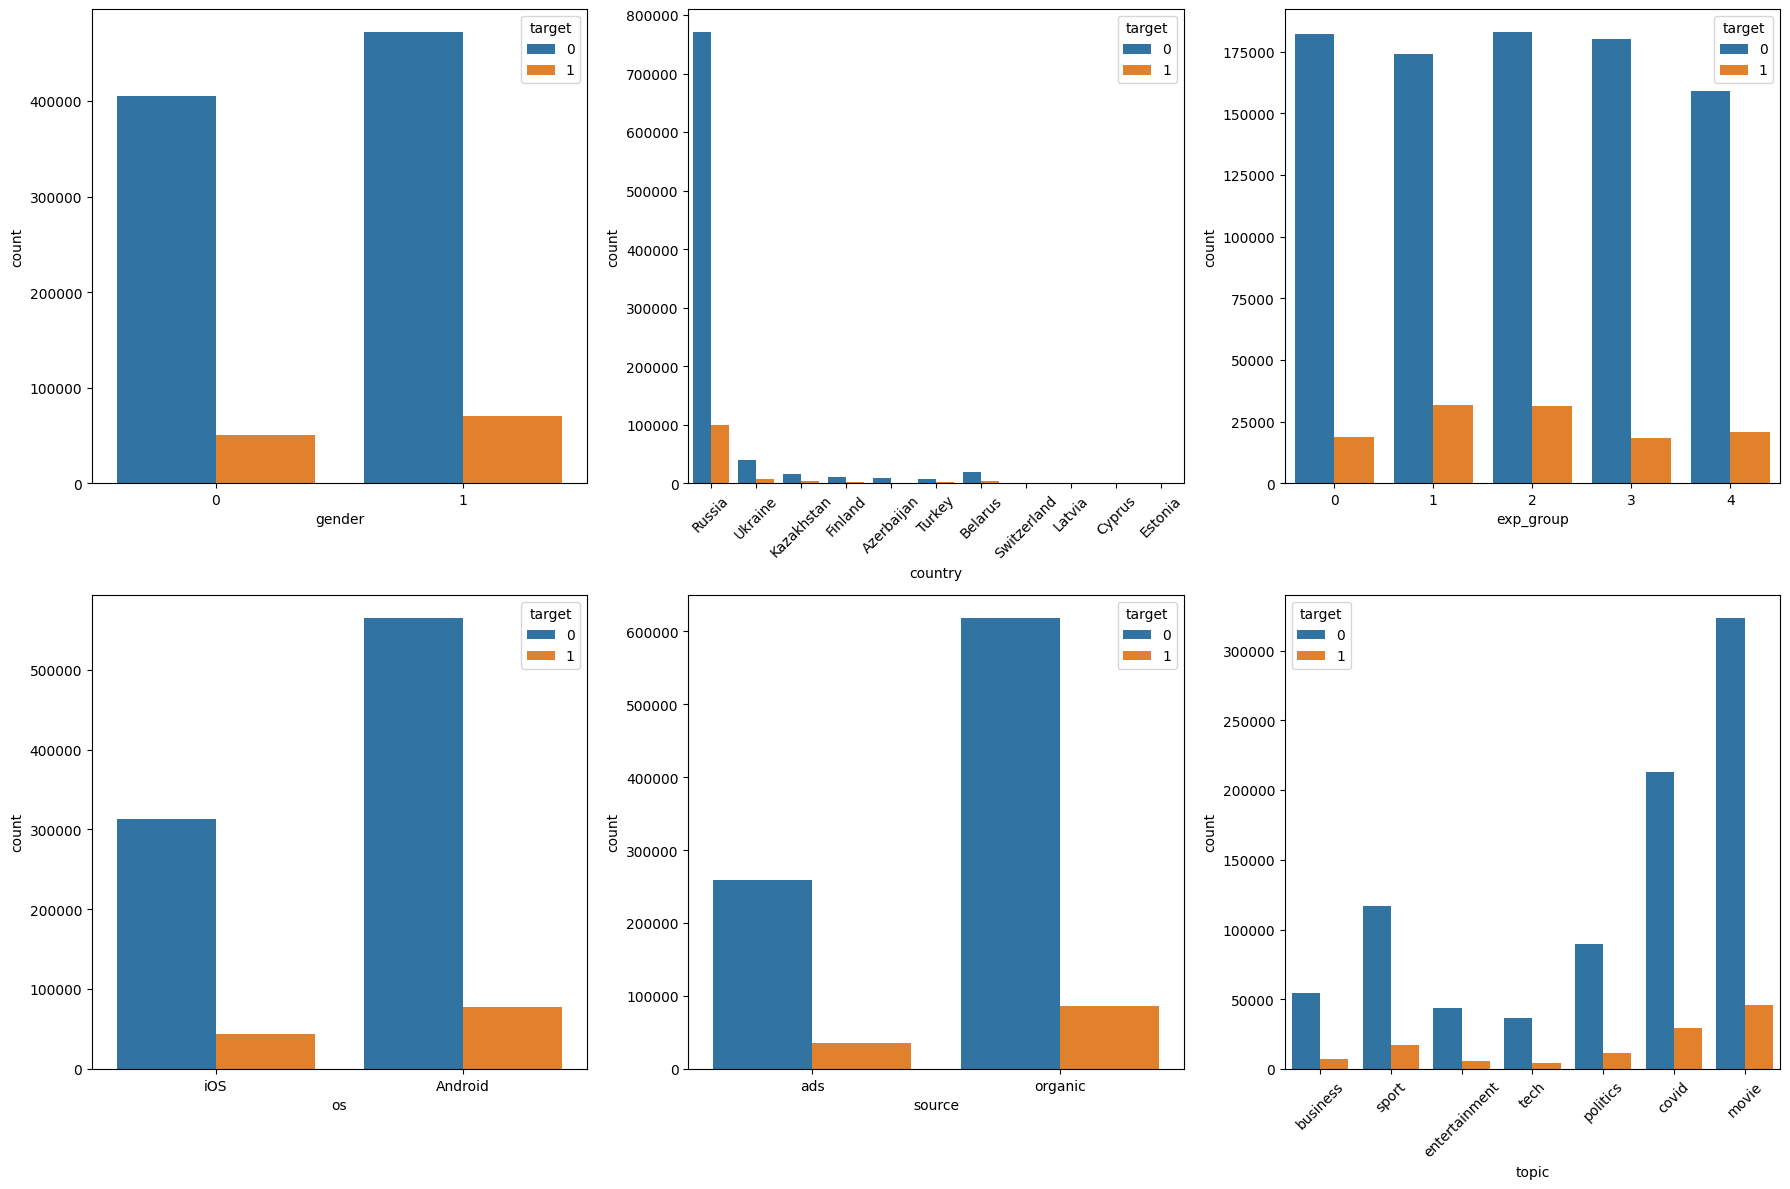

In [19]:
fig,ax =plt.subplots(2,3,figsize=(18,12))
for id, col_name in enumerate(cat_cols_for_boxplot):
    row, col = id//3, id%3
    if id in [1,5]:
        ax[row, col].tick_params(axis='x', labelrotation=45)
    sns.countplot(feed_features_default, x=col_name, hue="target", ax=ax[row, col])

plt.tight_layout()
